In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.models import Model
from keras import backend as K
from keras import regularizers, losses

from math import sqrt
from scipy.stats import norm

# Helper libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG,Markdown
from keras.utils.vis_utils import model_to_dot
from AETools import plotHistories, showImages, showImage, getDigits, plotEncodings, showLatentEncoding, noisifyData, showModels

print(tf.__version__)

2.9.0


# MNIST-Dataset

In [2]:
data = keras.datasets.mnist

# load the data
(tr_X, tr_Y), (te_X, te_Y) = data.load_data()

# normalise it
tr_X = tr_X / 255.0
te_X = te_X / 255.0

tr_X.shape, tr_Y.shape, te_X.shape, te_Y.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [3]:
tr_X = tr_X.reshape((len(tr_X),np.prod(tr_X.shape[1:])))
te_X = te_X.reshape((len(te_X),np.prod(te_X.shape[1:])))

tr_X.shape, te_X.shape

((60000, 784), (10000, 784))

In [4]:
latent_dim = 2

input_size = tr_X.shape[1]
kernel_regularizer='l1'



# Build the encoder ...
l_inp   = Input(shape=(input_size,), name='encoder_input')
t_in1   = Dense(256, activation='relu', name='enc1')(l_inp)
t_in2   = Dense(128, activation='relu', name='enc2')(t_in1)

t_mu = Dense(latent_dim, name='mu')(t_in2)
t_lv = Dense(latent_dim, name='lv')(t_in2)

encoder = Model(l_inp, t_mu)

In [5]:
batch_size = 100

# sampling function
def sampling(args):
    mu, lv = args
    eps = K.random_normal(shape=(batch_size, latent_dim), mean=0., stddev=1.0)
    return mu + K.exp(lv) * eps

t_lat = Lambda(sampling, output_shape=(latent_dim,), name='sampling')([t_mu, t_lv])


In [6]:
# Build the decoder ...


# decoder
l_dec1 = Dense(128, activation='relu', name='dec2')
l_dec2 = Dense(256, activation='relu', name='dec1')
l_out = Dense(input_size, activation='sigmoid', name='output')

t_dec1 = l_dec1(t_lat)
t_dec2 = l_dec2(t_dec1)
t_out = l_out(t_dec2)

In [7]:
# build model

reconstruction_loss_mse = losses.mean_squared_error(l_inp, t_out) * tr_X.shape[1]

kl_loss = 0.5 * K.sum(K.square(t_mu) + K.exp(t_lv) - t_lv - 1, axis = -1)
kl_factor = 1
kl_loss_weighed = kl_loss * kl_factor

# pick a combination:
#reconstruction_loss, name = reconstruction_loss_mse, 'autoenc-mse'
reconstruction_loss, name = reconstruction_loss_mse + kl_loss_weighed,  'autoenc-mse-%skl' % kl_factor


autoenc = Model(l_inp, t_out, name=name)

autoenc.add_loss(reconstruction_loss)

autoenc.add_metric(reconstruction_loss_mse, name='reconstruction-loss-mse')

autoenc.add_metric(kl_loss, name='kl')
if kl_factor != 1:
    autoenc.add_metric(kl_loss_weighed, name='kl-weighted-by-%s' % kl_factor)

autoenc.compile(optimizer='adam')



In [8]:
# build decoder
l_inp_dec = Input(shape=(latent_dim,), name='decoder_input')
t_dec1 = l_dec1(l_inp_dec)
t_dec2 = l_dec2(t_dec1)
_t_out = l_out(t_dec2)
decoder = Model(l_inp_dec, _t_out)

## ae

Model: "autoenc-mse-1kl"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 enc1 (Dense)                   (None, 256)          200960      ['encoder_input[0][0]']          
                                                                                                  
 enc2 (Dense)                   (None, 128)          32896       ['enc1[0][0]']                   
                                                                                                  
 mu (Dense)                     (None, 2)            258         ['enc2[0][0]']                   
                                                                                    

None

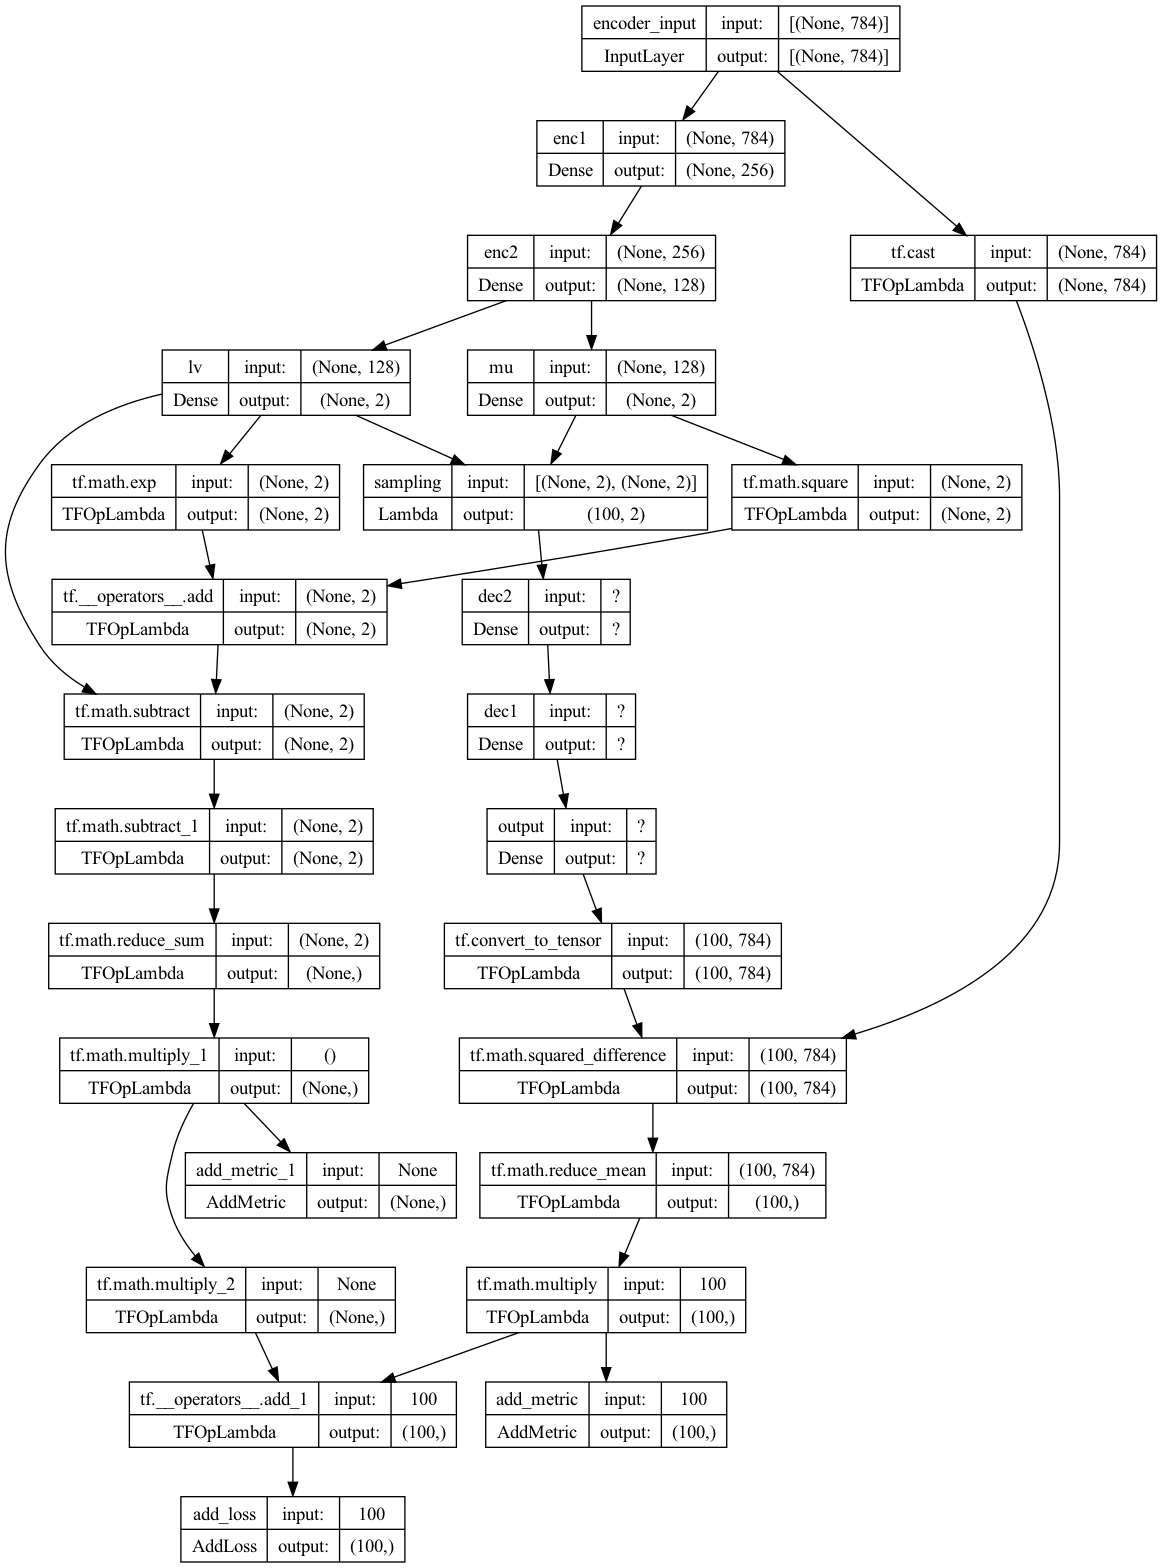

## dec

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dec2 (Dense)                multiple                  384       
                                                                 
 dec1 (Dense)                multiple                  33024     
                                                                 
 output (Dense)              multiple                  201488    
                                                                 
Total params: 234,896
Trainable params: 234,896
Non-trainable params: 0
_________________________________________________________________


None

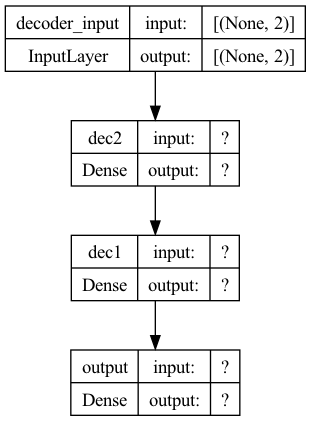

## enc

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 784)]             0         
                                                                 
 enc1 (Dense)                (None, 256)               200960    
                                                                 
 enc2 (Dense)                (None, 128)               32896     
                                                                 
 mu (Dense)                  (None, 2)                 258       
                                                                 
Total params: 234,114
Trainable params: 234,114
Non-trainable params: 0
_________________________________________________________________


None

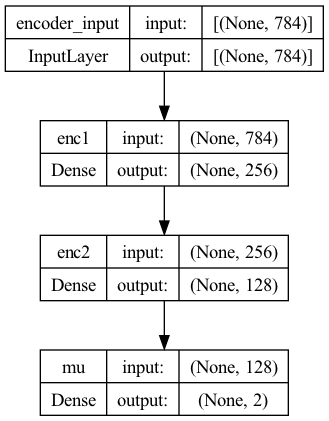

In [9]:
showModels(ae=autoenc, dec=decoder, enc=encoder)

In [10]:
autoenc.input_shape, autoenc.output_shape, tr_X.shape

((None, 784), (100, 784), (60000, 784))

In [11]:
# train
h = autoenc.fit(tr_X,  epochs=20, batch_size=batch_size, 
        #validation_data=(te_X, None), 
        verbose=1)

Epoch 1/20


2023-06-16 08:33:54.679604: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


600/600 [==============================] - 2s 3ms/step - loss: 51.9384 - reconstruction-loss-mse: 50.7565 - kl: 1.1819
Epoch 2/20
600/600 [==============================] - 2s 3ms/step - loss: 42.2144 - reconstruction-loss-mse: 40.1300 - kl: 2.0844
Epoch 3/20
600/600 [==============================] - 2s 3ms/step - loss: 39.3088 - reconstruction-loss-mse: 36.9969 - kl: 2.3119
Epoch 4/20
600/600 [==============================] - 2s 3ms/step - loss: 37.7474 - reconstruction-loss-mse: 35.3098 - kl: 2.4375
Epoch 5/20
600/600 [==============================] - 2s 3ms/step - loss: 36.8698 - reconstruction-loss-mse: 34.3703 - kl: 2.4995
Epoch 6/20
600/600 [==============================] - 2s 3ms/step - loss: 36.2248 - reconstruction-loss-mse: 33.6803 - kl: 2.5446
Epoch 7/20
600/600 [==============================] - 2s 3ms/step - loss: 35.8098 - reconstruction-loss-mse: 33.2344 - kl: 2.5754
Epoch 8/20
600/600 [==============================] - 2s 4ms/step - loss: 35.4273 - reconstruction-lo

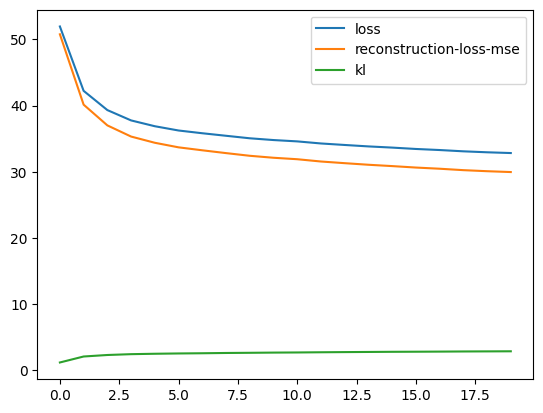

In [12]:
for k,vs in h.history.items():
    plt.plot(vs, label=k)
plt.legend()
plt.show()

In [13]:
tr_X_ae = encoder.predict(tr_X, batch_size=batch_size)
print(tr_X_ae.shape)
tr_X_de = decoder.predict(tr_X_ae, batch_size=batch_size)
print(tr_X_de.shape)
tr_X_dd = autoenc.predict(tr_X, batch_size=batch_size)

600/600 [==============================] - 1s 851us/step
(60000, 2)
600/600 [==============================] - 1s 863us/step
(60000, 784)
600/600 [==============================] - 1s 1ms/step


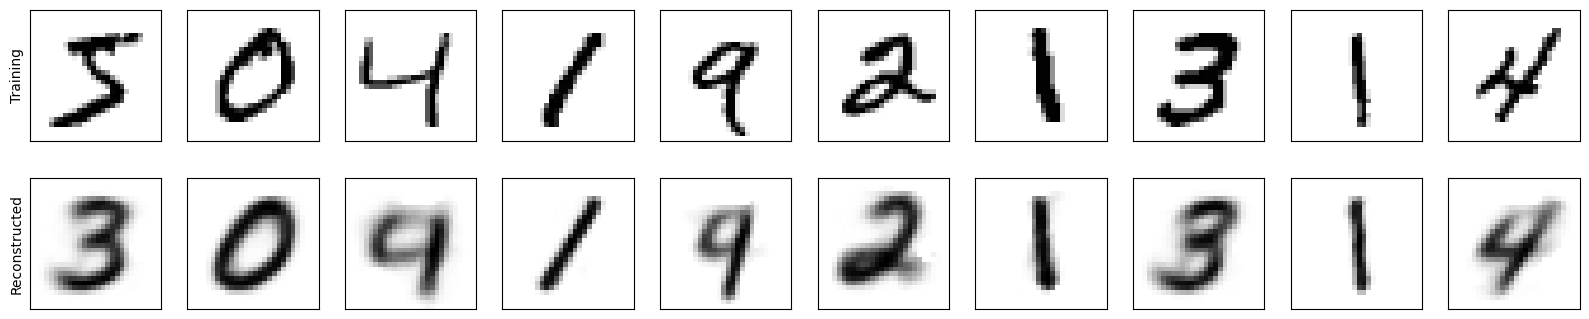

In [14]:
showImages(10, Training=tr_X, Reconstructed=tr_X_de)

We can also look at the encoding for a number of images:

In [15]:
for i in range(5):
    print(tr_X_ae[i])

[-0.14219195 -0.35229912]
[-0.2184226   0.06780712]
[0.2311915  0.58141935]
[-1.0507619 -1.6951432]
[0.0255566 1.2753538]


We split the training data into slices - one slice containing 50 images for each of the digits. The plot shows 10 random samples for every slice.

In [16]:
Digits = getDigits(tr_X, tr_Y,show=False)

For each of the slices, we will plot the activation of the hidden layer, i.e., the learned encoding for the different digits. Please note that there are some observable patterns - similar to the binary encoding for the 838-Autoencoder of the first lecture.

2/2 [==============================] - 0s 891us/step


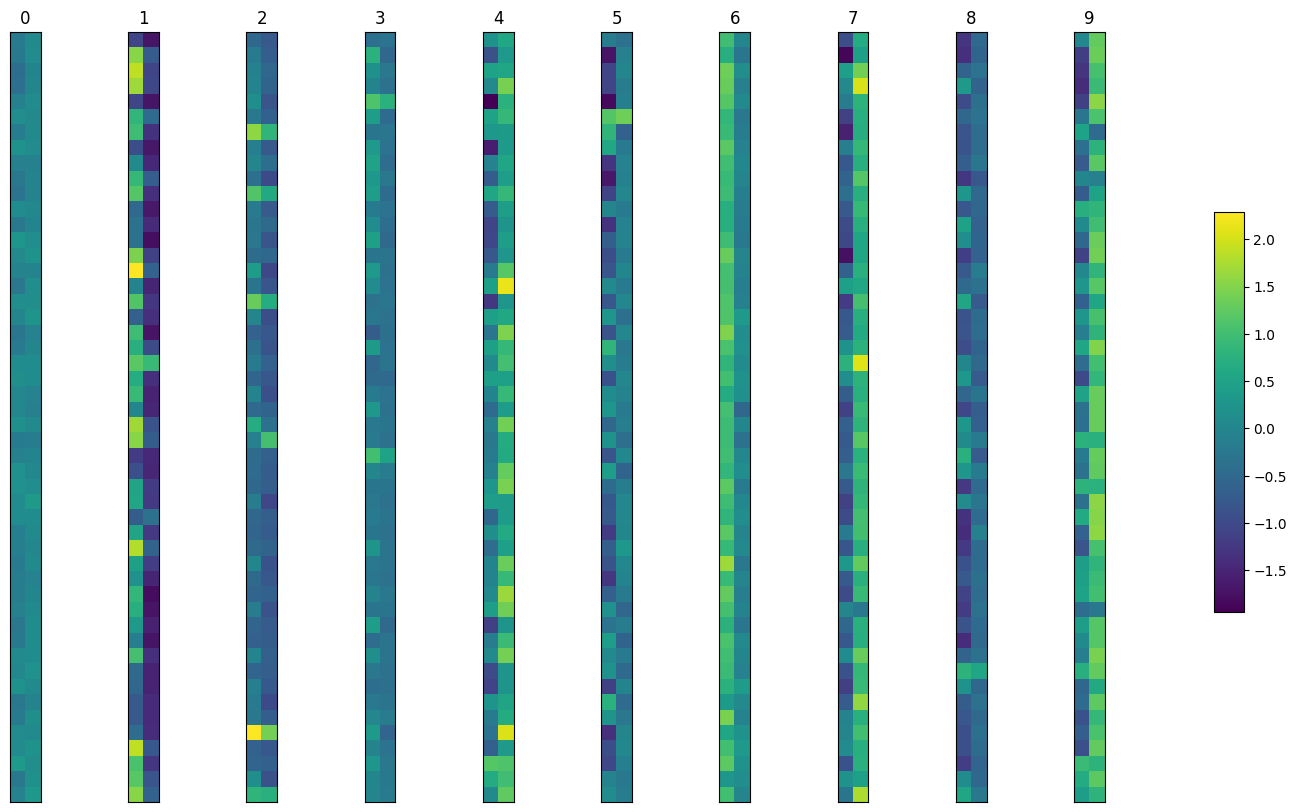

In [17]:
plotEncodings(encoder, Digits)

313/313 [==============================] - 0s 471us/step


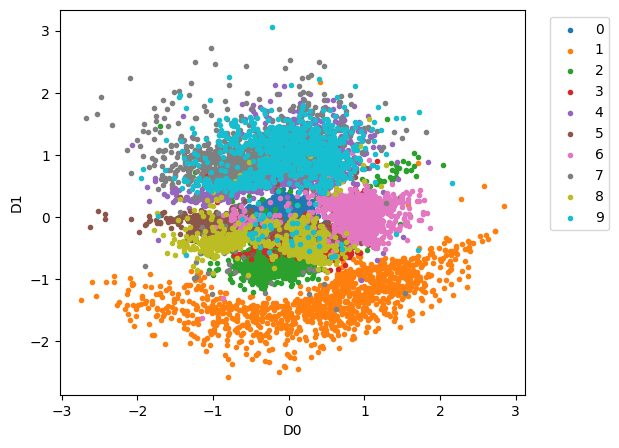

The latent encodings have mean=-0.00327, and std=0.74848


,0,1
count,10000.000000,10000.000000
mean,0.006093,-0.012626
std,0.704958,0.789567
min,-2.745138,-2.583824
25%,-0.434883,-0.508313
50%,-0.007333,-0.092827
75%,0.444675,0.598253
max,2.839916,3.056327


In [18]:
te_X_latent = encoder.predict(te_X)
showLatentEncoding(te_X_latent, te_Y)

-2.745138 2.8399155 -2.5838244 3.0563269


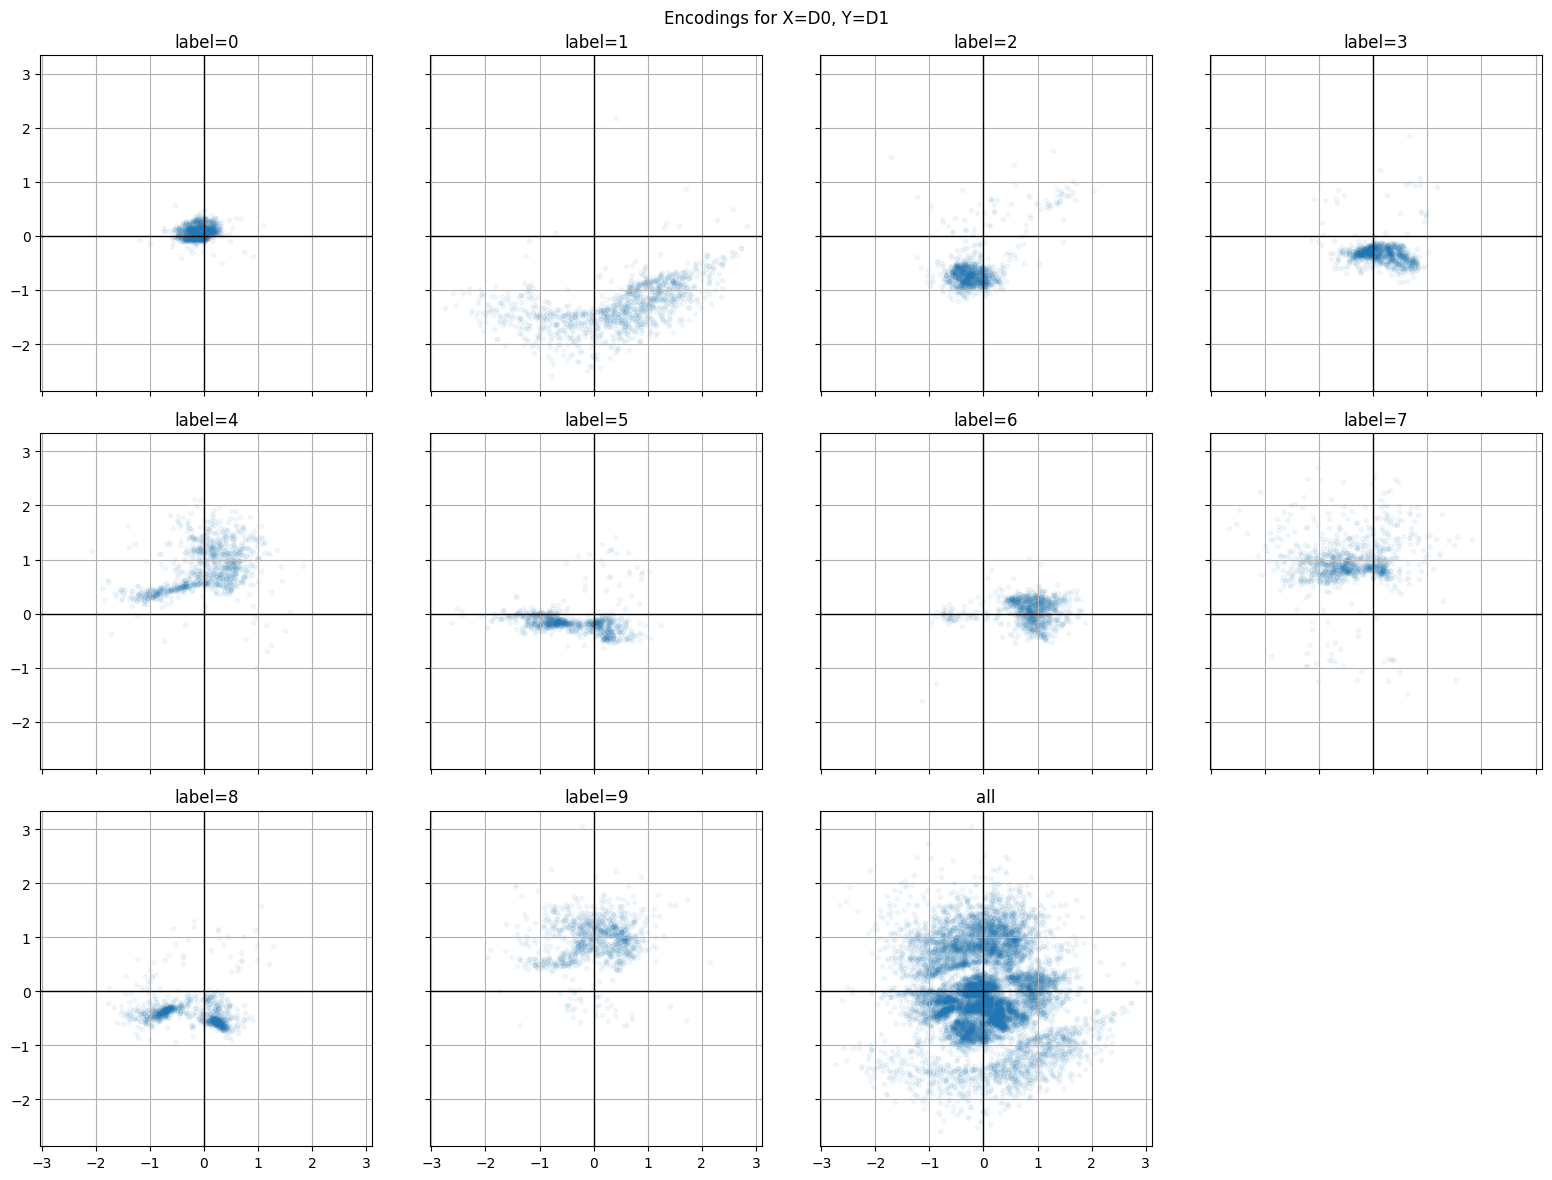

In [19]:
def showLatentEncoding4label(encodings, labels, d0=0, d1=1, describe=True, alpha=0.05, show_bg=False):
    def show_bg(ax, mu_x=0, mu_y=0, bg_c = 99):
        xs = np.linspace(xmin, xmax, num=bg_c)
        ys = np.linspace(ymin, ymax, num=bg_c)
        xx, yy = np.meshgrid(xs, ys)

        g_sig = 1
        kernel = np.exp(-0.5 * (np.square(xx) + np.square(yy)) / np.square(g_sig))
        kernel /= np.sum(kernel)
        
        ax.imshow(kernel, interpolation='none', extent=(xmin, xmax, ymin, ymax), cmap='gray_r', 
                  alpha=0.5)#, vmin=0, vmax=1)




    xmin, xmax = encodings[:, d0].min(), encodings[:, d0].max()
    ymin, ymax = encodings[:, d1].min(), encodings[:, d1].max()
    print(xmin,xmax,ymin,ymax)

    fig_scale = 4
    all_labels = np.unique(labels)
    n_all_labels = len(all_labels) + 1
    
    nrows = int(np.floor(np.sqrt(n_all_labels)))
    ncols = int(np.ceil(n_all_labels / nrows))
    
    f, axs = plt.subplots(nrows=nrows, ncols=ncols, 
                          sharex=True, sharey=True, 
                          squeeze=False,
                          figsize=(ncols*fig_scale, nrows*fig_scale))
    axsf = axs.flatten()

    for i,l in enumerate(all_labels):
        ax = axsf[i]
        ax.set_aspect('equal')
        ix = np.where(labels == l)[0]
    
        les = encodings[ix]
        lls = labels[ix]
    
        ax.scatter(les[:, d0], les[:, d1], marker='.', alpha=alpha)
        ax.set_title('label=%s' % l)
        ax.axhline(0, color='k', lw=1)
        ax.axvline(0, color='k', lw=1)
        #show_bg(ax, mu_x=i)

        ax.grid()

    ax = axsf[i+1]
    ax.scatter(encodings[:, d0], encodings[:, d1], marker='.', alpha=alpha)
    ax.set_title('all')
    ax.axhline(0, color='k', lw=1)
    ax.axvline(0, color='k', lw=1)
    ax.grid()
    ax.set_aspect('equal')

    f.delaxes(axsf[i+2])
    
    #show_bg(ax)

    plt.suptitle('Encodings for X=D%i, Y=D%i' % (d0, d1))
    plt.tight_layout()
    plt.show()

showLatentEncoding4label(te_X_latent, te_Y, show_bg = True)


# Apply to Noise

600/600 [==============================] - 1s 1ms/step


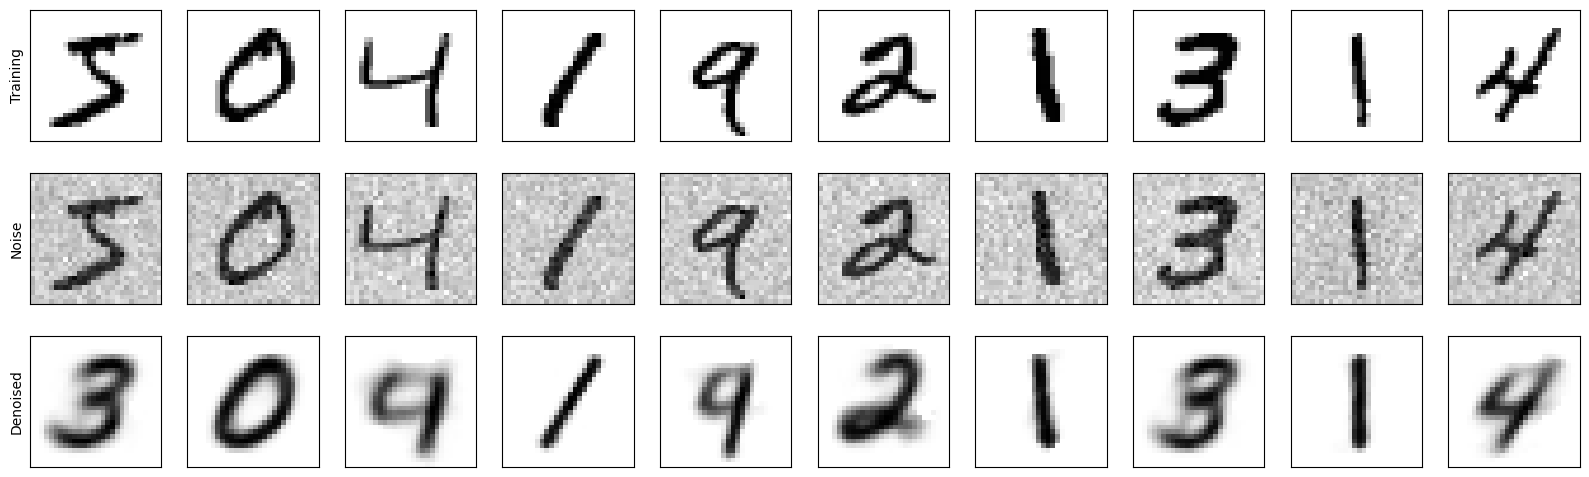

In [20]:
tr_X_n = noisifyData(tr_X)

tr_X_n_ae = encoder.predict(tr_X_n, batch_size=batch_size)
tr_X_n_de = autoenc.predict(tr_X_n, batch_size=batch_size)

showImages(10, Training=tr_X, Noise=tr_X_n, Denoised=tr_X_n_de)

# Show generated images

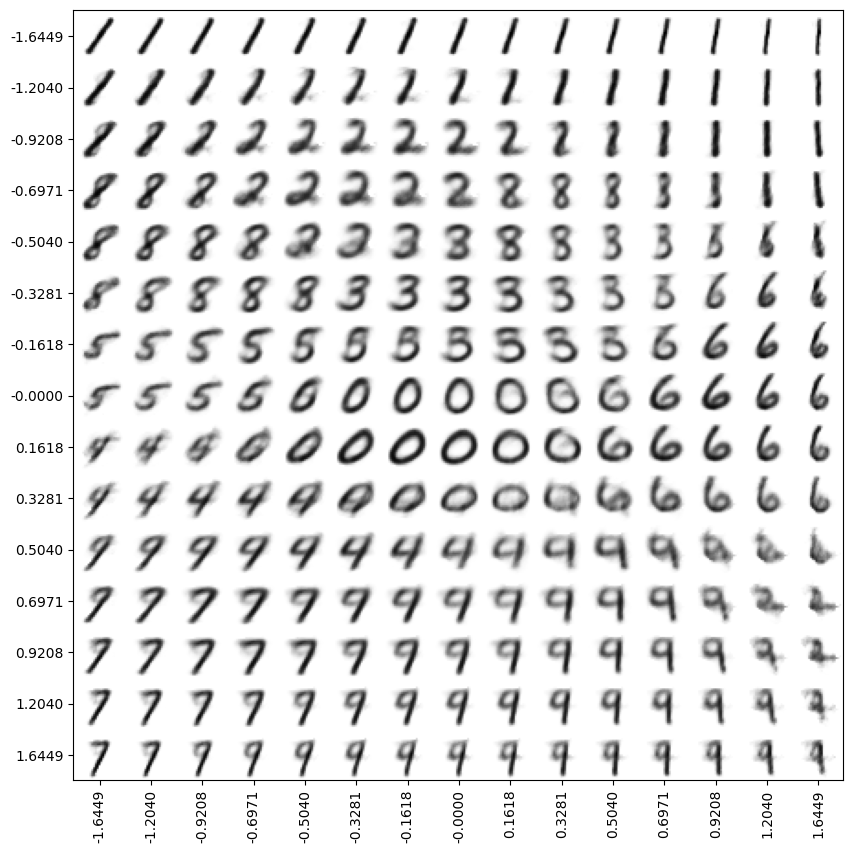

In [21]:
# display a 2D manifold of the digits
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit
grid_p = [i*digit_size + digit_size/2 for i in range(n)]
grid_x_l = [ "%.4f"%v for v in grid_x ] 
grid_y_l = [ "%.4f"%v for v in grid_y ] 
plt.figure(figsize=(10, 10))
showImage(figure, showDetails="", show=False)
plt.xticks(grid_p,grid_x_l, rotation='vertical')
plt.yticks(grid_p,grid_y_l)
plt.show()

1/1 [==============================] - 0s 5ms/step


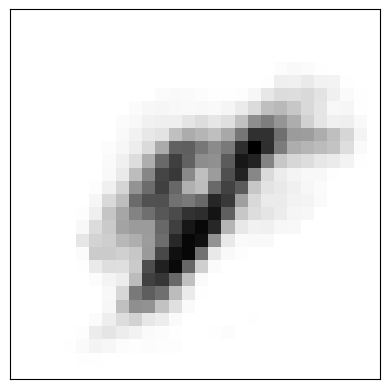

In [22]:
x_decoded = decoder.predict(np.array([[-1.6, 0.16]]))
showImage(x_decoded.reshape(digit_size,digit_size), showDetails="")

1/1 [==============================] - 0s 5ms/step


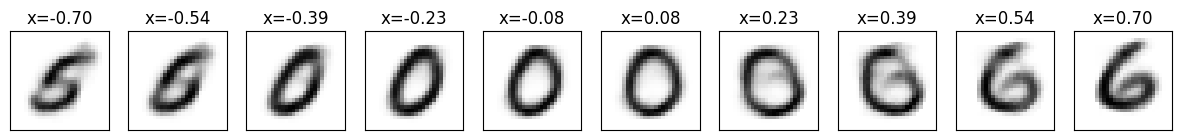

In [23]:
#x = -0.5 ... 0.5
y = 0
n = 10
plt.figure(figsize=(15,5))
for i,x in enumerate(np.linspace(-0.7, 0.7, n)):
    x_decoded = decoder.predict(np.array([[x, y]]))
    plt.subplot(1,n,i+1)
    showImage(x_decoded.reshape(digit_size,digit_size), showDetails="", x='%.2f' % x,  show=False)

plt.show()
